In [26]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

In [27]:
import json
import folium
import random

with open("barris-barrios.json", "r", encoding="utf-8") as f:
    barrios_data = json.load(f)

m = folium.Map(location=[39.4702, -0.3768], zoom_start=12, control_scale=True)

for barrio in barrios_data:
    nombre = barrio['nombre']
    geo_shape = barrio.get('geo_shape', {})

    # Localizamos las coordenadas:
    try:
        coords = geo_shape['geometry']['coordinates'][0]
    except (KeyError, IndexError, TypeError):
        print(f"No se pudieron leer las coordenadas del polígono para {nombre}")
        continue

    coords_latlon = [(c[1], c[0]) for c in coords]

    # Creamos un color aleatorio para cada polígono
    fill_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))

    # Añadimos el polígono al mapa
    folium.Polygon(
        locations=coords_latlon,
        color="black",        # Borde
        weight=1.5,           # Grosor del borde
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.6,
        popup=nombre
    ).add_to(m)

    center = barrio.get('geo_point_2d')
    if center:
        lat = center['lat']
        lon = center['lon']
        # folium.Marker(
        #     location=[lat, lon],
        #     popup=f"{nombre}",
        #     icon=folium.Icon(color="blue", icon="info-sign")
        # ).add_to(m)

map_filename = "valencia_barrios.html"
m.save(map_filename)
m

In [28]:
area = {}

# Calcular las áreas y almacenarlas
for b1 in barrios_data:
    area[b1['nombre']] = b1['gis_gis_barrios_area']

# Calcular la media sin contar los valores None
valores_area = [v for v in area.values() if v is not None]
media_area = sum(valores_area) / len(valores_area) if valores_area else 0

# Sustituir los None por la media
for key, value in area.items():
    if value is None:
        area[key] = media_area

area

{"L'HORT DE SENABRE": 4263543.125,
 'CIUTAT JARDI': 5027684.202571428,
 'CAMI DE VERA': 5027684.202571428,
 'EL PALMAR': 5027684.202571428,
 'EL PERELLONET': 5027684.202571428,
 'VARA DE QUART': 5027684.202571428,
 'SOTERNES': 5027684.202571428,
 'LA FONTSANTA': 5027684.202571428,
 'EL BOTANIC': 3701155.9375,
 'BORBOTO': 5027684.202571428,
 'BENIFARAIG': 14228152.5,
 'TORMOS': 279952.0,
 'SANT ANTONI': 2497340.9375,
 'BENIMACLET': 7431831.875,
 'MARXALENES': 3903659.375,
 'EXPOSICIO': 3816096.875,
 'BETERO': 2553075.3125,
 'CABANYAL-CANYAMELAR': 1349264.0,
 'MESTALLA': 8435878.75,
 'EL PILAR': 1616061.5625,
 'EL PLA DEL REMEI': 3869178.4375,
 'ALBORS': 2560381.0938,
 'ARRANCAPINS': 8743740.625,
 'EN CORTS': 3640261.875,
 'POBLE NOU': 5027684.202571428,
 'LA TORRE': 5027684.202571428,
 'SANT FRANCESC': 4386583.125,
 'PENYA-ROJA': 9111358.75,
 'ELS ORRIOLS': 5027684.202571428,
 'FAVARA': 2802505.625,
 'CAMI REAL': 1477502.0,
 'LA FONTETA S.LLUIS': 2388267.3438,
 'LA PUNTA': 5027684.20257

In [29]:
import math
dist_matrix = {}
for b1 in barrios_data:
    for b2 in barrios_data:
        lat1, lon1 = b1["geo_point_2d"]["lat"], b1["geo_point_2d"]["lon"]
        lat2, lon2 = b2["geo_point_2d"]["lat"], b2["geo_point_2d"]["lon"]
        dist = math.sqrt((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2) * 110  # Aproximación en km
        if dist == 0.0:
            # dist = math.sqrt(area[b1['nombre']])
            dist = random.uniform(1, 3)
        dist_matrix[(b1["nombre"], b2["nombre"])] = dist
dist_matrix

{("L'HORT DE SENABRE", "L'HORT DE SENABRE"): 2.07239599531039,
 ("L'HORT DE SENABRE", 'CIUTAT JARDI'): 5.51503330014322,
 ("L'HORT DE SENABRE", 'CAMI DE VERA'): 5.781308780841824,
 ("L'HORT DE SENABRE", 'EL PALMAR'): 13.50918134076804,
 ("L'HORT DE SENABRE", 'EL PERELLONET'): 20.10196866241257,
 ("L'HORT DE SENABRE", 'VARA DE QUART'): 1.9786262784797233,
 ("L'HORT DE SENABRE", 'SOTERNES'): 2.984949983049285,
 ("L'HORT DE SENABRE", 'LA FONTSANTA'): 2.537935478531245,
 ("L'HORT DE SENABRE", 'EL BOTANIC'): 2.7611346694193846,
 ("L'HORT DE SENABRE", 'BORBOTO'): 7.443352473523906,
 ("L'HORT DE SENABRE", 'BENIFARAIG'): 8.183791091949265,
 ("L'HORT DE SENABRE", 'TORMOS'): 4.342759257009777,
 ("L'HORT DE SENABRE", 'SANT ANTONI'): 4.52618560299521,
 ("L'HORT DE SENABRE", 'BENIMACLET'): 5.018218492750196,
 ("L'HORT DE SENABRE", 'MARXALENES'): 3.8872806100142205,
 ("L'HORT DE SENABRE", 'EXPOSICIO'): 4.029760188770623,
 ("L'HORT DE SENABRE", 'BETERO'): 6.411114722269834,
 ("L'HORT DE SENABRE", 'CA

In [30]:
import os
import math
import random
import json
from itertools import permutations

from Melodie import (
    Config,
    Simulator,
    Scenario,
    DataLoader,
    Environment,
    Agent,
    Model
)

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

###############################################################################
# 1) CONFIG
###############################################################################
class WasteCollectionConfig(Config):
    def __init__(self, total_steps, num_trucks, storage_barrios=[], random_seed=42, data_dir='resultados'):
        super().__init__(
            project_name="waste_collection",
            project_root=os.getcwd(),
            input_folder="input",
            output_folder="output"
        )
        self.total_steps = total_steps
        self.num_trucks = num_trucks
        self.max_capacity_container = 25
        self.max_capacity_truck = 1000
        self.threshold = 0.9  # 90% de la capacidad máxima
        self.cost_per_km = 1
        self.cost_per_truck = 10
        self.storage_barrios = storage_barrios
        self.random_seed = random_seed  # Semilla para reproducibilidad
        self.data_dir = data_dir

###############################################################################
# 2) DATA LOADER
###############################################################################
class WasteCollectionDataLoader(DataLoader):
    def __init__(self, simulator, config, scenario_cls):
        super().__init__(simulator, config, scenario_cls)

    def generate_scenarios(self, manager_type: str):
        scenario = WasteCollectionScenario()
        self.load(scenario)
        return [scenario]

    def load(self, scenario: "WasteCollectionScenario"):
        with open("barris-barrios.json", "r", encoding="utf-8") as f:
            barrios_data = json.load(f)
        scenario.barrios_data = barrios_data

###############################################################################
# 3) SCENARIO
###############################################################################
class WasteCollectionScenario(Scenario):
    def __init__(self):
        super().__init__()
        self.barrios_data = []

    def setup(self):
        pass

###############################################################################
# 4) ENVIRONMENT
###############################################################################
class WasteCollectionEnvironment(Environment):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.barrios = []
        self.dist_matrix = {}
        self.area = {}  # Diccionario para almacenar el área de cada barrio

    def setup(self):
        scenario = self.model.scenario
        self.barrios = scenario.barrios_data
        self._build_dist_matrix()
        self._build_area_dict()

    def _build_dist_matrix(self):
        """Construir la matriz de distancias entre los barrios."""
        for b1 in self.barrios:
            for b2 in self.barrios:
                lat1, lon1 = b1["geo_point_2d"]["lat"], b1["geo_point_2d"]["lon"]
                lat2, lon2 = b2["geo_point_2d"]["lat"], b2["geo_point_2d"]["lon"]
                dist = math.sqrt((lat2 - lat1) ** 2 + (lon2 - lon1) ** 2) * 110  # Aproximación en km
                self.dist_matrix[(b1["nombre"], b2["nombre"])] = dist

    def _build_area_dict(self):
        """Construir un diccionario de áreas para cada barrio."""
        # Suponiendo que cada barrio tiene una clave 'area'
        for barrio in self.barrios:
            self.area[barrio["nombre"]] = barrio.get("area", 1000000)  # Valor por defecto si no está presente

    def calculate_route_cost(self, route):
        """Calcular el costo de una ruta sumando las distancias entre barrios consecutivos."""
        cost = 0.0
        for i in range(len(route) - 1):
            cost += self.dist_matrix.get((route[i], route[i + 1]), 0)
        return cost

    def find_shortest_hamiltonian_cycle(self, start_barrio, barrios_subset):
        """
        Encuentra un ciclo hamiltoniano usando el algoritmo del vecino más cercano
        y mejora la ruta con una búsqueda local (Hill Climbing).
        """
        if not barrios_subset:
            return [start_barrio], 0.0

        # Asegurarse de que el barrio de inicio esté en el conjunto
        barrios_to_visit = set(barrios_subset)
        barrios_to_visit.add(start_barrio)

        route = [start_barrio]
        total_cost = 0.0
        current_barrio = start_barrio
        barrios_to_visit.remove(current_barrio)

        while barrios_to_visit:
            # Encuentra el barrio más cercano
            next_barrio = min(
                barrios_to_visit,
                key=lambda b: self.dist_matrix.get((current_barrio, b), float('inf'))
            )
            route.append(next_barrio)
            total_cost += self.dist_matrix.get((current_barrio, next_barrio), 0)
            current_barrio = next_barrio
            barrios_to_visit.remove(next_barrio)

        # Regresar al barrio de inicio para completar el ciclo
        # Eliminamos esta línea para permitir regresar al almacén más cercano
        # route.append(start_barrio)
        # total_cost += self.dist_matrix.get((current_barrio, start_barrio), 0)

        # Aplicar búsqueda local (Hill Climbing) para mejorar la ruta
        improved_route, improved_cost = self.hill_climbing(route, total_cost)
        return improved_route, improved_cost

    def hill_climbing(self, route, current_cost):
        """
        Implementa el algoritmo Hill Climbing para mejorar la ruta existente.
        """
        best_route = route
        best_cost = current_cost
        improved = True

        while improved:
            improved = False
            neighbors = self.generate_neighbors(best_route)
            for neighbor in neighbors:
                neighbor_cost = self.calculate_total_cost(neighbor)
                # Añadir el log de los camiones al costo final solo una vez
                neighbor_cost += math.log(len(self.model.trucks)) if len(self.model.trucks) > 0 else 0
                if neighbor_cost < best_cost:
                    best_route = neighbor
                    best_cost = neighbor_cost
                    improved = True
                    break  # Salir del bucle para reiniciar la búsqueda
            # Si no se encontró una mejora, el bucle se detiene

        return best_route, best_cost

    def generate_neighbors(self, route):
        """
        Genera todas las posibles rutas vecinas cambiando la posición de dos barrios.
        """
        neighbors = []
        # Excluir el primer y último barrio (inicio y fin del ciclo)
        for i in range(1, len(route) - 1):
            for j in range(i + 1, len(route) - 1):
                if i != j:
                    new_route = route.copy()
                    # Intercambiar dos barrios
                    new_route[i], new_route[j] = new_route[j], new_route[i]
                    neighbors.append(new_route)
        return neighbors

    def calculate_total_cost(self, route):
        """
        Calcula el costo total de una ruta dada.
        """
        total = 0.0
        for i in range(len(route) - 1):
            total += self.dist_matrix.get((route[i], route[i+1]), float('inf'))
        return total

    def apply_kmeans(self, barrios_desbordados, num_clusters):
        """
        Aplica KMeans a las coordenadas de los barrios desbordados para agruparlos en clusters.
        """
        # Obtener las coordenadas de los barrios desbordados
        coords = [(barrio["geo_point_2d"]["lat"], barrio["geo_point_2d"]["lon"]) for barrio in barrios_desbordados]

        if len(coords) < num_clusters:
            kmeans = KMeans(n_clusters=len(coords), random_state=self.model.config.random_seed)
            kmeans.fit(coords)
        else:
            kmeans = KMeans(n_clusters=num_clusters, random_state=self.model.config.random_seed)
            kmeans.fit(coords)

        # Agrupar los barrios en clusters
        barrio_clusters = {i: [] for i in range(num_clusters)}
        for idx, label in enumerate(kmeans.labels_):
            barrio_clusters[label].append(barrios_desbordados[idx])

        return barrio_clusters

    def find_closest_storage_barrio(self, barrio_name):
        """
        Encuentra el barrio almacén más cercano al barrio dado.
        """
        min_dist = float('inf')
        closest_barrio = None
        for storage_barrio in self.model.storage_barrios:
            dist = self.dist_matrix.get((barrio_name, storage_barrio), float('inf'))
            if dist < min_dist:
                min_dist = dist
                closest_barrio = storage_barrio
        return closest_barrio

    def step(self):
        # 1. Generar basura en cada contenedor
        for container in self.model.containers:
            container.generate_waste()

        # 2. Identificar barrios con basura desbordada
        overflowing_barrios = set([c.barrio_name for c in self.model.containers if c.is_full(self.model.config.threshold)])

        if not overflowing_barrios:
            return

        # Filtrar barrios desbordados
        barrios_desbordados = [barrio for barrio in self.barrios if barrio["nombre"] in overflowing_barrios]

        # 3. Aplicar KMeans para asignar barrios desbordados a camiones basados en la proximidad
        barrio_clusters = self.apply_kmeans(barrios_desbordados, self.model.config.num_trucks)

        # 4. Asignar barrios a camiones
        assignments = {truck.truck_id: [] for truck in self.model.trucks}
        for i, truck in enumerate(self.model.trucks):
            assigned_barrios = barrio_clusters[i] if i in barrio_clusters else []
            assignments[truck.truck_id] = [barrio["nombre"] for barrio in assigned_barrios]

        # 5. Asignar rutas a los camiones
        for truck in self.model.trucks:
            assigned_barrios = assignments[truck.truck_id]
            if not assigned_barrios:
                truck.route = [truck.current_storage_barrio]
                truck.cost_incurred = 0.0
                continue

            # Definir el barrio almacén actual como punto de inicio
            start_barrio = truck.current_storage_barrio

            # Calcular ciclo hamiltoniano dentro de los barrios asignados, comenzando en el almacén
            route, _ = self.find_shortest_hamiltonian_cycle(start_barrio, assigned_barrios)

            # Asignar la ruta sin agregar el almacén al final
            truck.route = route

        # 6. Ejecutar las rutas de los camiones
        for truck in self.model.trucks:
            truck.run_route()

###############################################################################
# 5) AGENTS
###############################################################################
class ContainerAgent(Agent):
    def __init__(self, agent_id, model, barrio_name):
        super().__init__(agent_id)
        self.id = agent_id
        self.model = model
        self.barrio_name = barrio_name
        self.current_waste = 0.0

    def setup(self):
        self.max_capacity = self.model.config.max_capacity_container

    def generate_waste(self):
        env = self.model.environment
        dist = env.dist_matrix.get(('RUSSAFA', self.barrio_name), 1)  # Evitar división por cero
        area = env.area.get(self.barrio_name, 1000000)  # Valor por defecto si no está presente
        new_waste = random.uniform(5,10) * (1/(dist + 1)) * (area / 1000000)
        self.current_waste += new_waste
        #print(f"Barrio {self.barrio_name} generó {new_waste:.2f} de basura. Total: {self.current_waste:.2f}")
        # self.current_waste = (random.uniform(90, 99) / 10) * self.max_capacity

    def empty(self):
        #print(f"Barrio {self.barrio_name} ha sido vaciado. Basura antes: {self.current_waste:.2f}")
        self.current_waste = 0.0

    def try_empty(self, max_capacity, current_load):
        if self.current_waste > (max_capacity - current_load):
            self.current_waste -= (max_capacity - current_load)
            return max_capacity, False
        else:
            return current_load + self.current_waste, True

    def is_full(self, threshold=0.9):
        return self.current_waste >= threshold * self.max_capacity

class TruckAgent(Agent):
    def __init__(self, agent_id, model, truck_id, storage_barrio):
        super().__init__(agent_id)
        self.model = model
        self.truck_id = truck_id
        self.current_storage_barrio = storage_barrio  # Barrio almacén actual
        self.route = []
        self.cost_incurred = 0.0
        self.current_load = 0.0

    def setup(self):
        self.max_capacity = self.model.config.max_capacity_truck

    def run_route(self):
        if not self.route:
            #print(f"Camión {self.truck_id} no tiene ruta para este paso.")
            return

        #print(f"Camión {self.truck_id} comienza en {self.current_storage_barrio} y ejecuta la ruta: {self.route} con costo: {self.cost_incurred:.2f}")
        init_pos = self.current_storage_barrio
        total_cost = 0.0
        real_route = [init_pos]
        self.current_load = 0.0

        for next_barrio in self.route[1:]:
            # Calcular el costo entre el barrio actual y el siguiente
            env = self.model.environment
            cost = env.dist_matrix.get((init_pos, next_barrio), 0)
            total_cost += cost * 1
            real_route.append(next_barrio)

            # Intentar vaciar los contenedores en el siguiente barrio
            containers_in_barrio = [c for c in self.model.containers if c.barrio_name == next_barrio and c.is_full()]
            for container in containers_in_barrio:
                self.current_load, is_empty = container.try_empty(self.max_capacity, self.current_load)
                #print(f'Camión {self.truck_id} vació el contenedor {container.id} en {next_barrio}. Carga actual: {self.current_load:.2f}')
                if self.current_load >= self.max_capacity:
                    # Si la carga excede la capacidad, volver al almacén más cercano para descargar
                    closest_storage = env.find_closest_storage_barrio(next_barrio)
                    cost_to_storage = env.dist_matrix.get((next_barrio, closest_storage), 0)
                    total_cost += cost_to_storage * 1
                    real_route.append(closest_storage)
                    #print(f'Camión {self.truck_id} excedió la carga. Volviendo a {closest_storage} para descargar.')
                    self.current_storage_barrio = closest_storage
                    self.current_load = 0.0
                    break  # Salir del loop para reiniciar la ruta desde el almacén

            init_pos = next_barrio

        # Después de completar la ruta, regresar al almacén más cercano
        if real_route[-1] != self.current_storage_barrio:
            env = self.model.environment
            closest_storage = env.find_closest_storage_barrio(real_route[-1])
            if closest_storage != real_route[-1]:
                cost_to_storage = env.dist_matrix.get((real_route[-1], closest_storage), 0)
                total_cost += cost_to_storage * 1
                real_route.append(closest_storage)
                #print(f'Camión {self.truck_id} regresó al almacén más cercano: {closest_storage}')
                self.current_storage_barrio = closest_storage

        self.cost_incurred = total_cost
        self.route = real_route.copy()

###############################################################################
# 6) MODEL
###############################################################################
class WasteCollectionModel(Model):
    def __init__(self, config, scenario, run_id_in_scenario=None, visualizer=None):
        super().__init__(config, scenario, run_id_in_scenario=run_id_in_scenario, visualizer=visualizer)
        self.config = config
        self.scenario = scenario

    def setup(self, time_threshold=3):
        # Establecer la semilla para reproducibilidad
        #random.seed(self.config.random_seed)
        #np.random.seed(self.config.random_seed)

        self.storage_barrios = self.config.storage_barrios
        self.environment = WasteCollectionEnvironment(self)
        self.environment.setup()
        self.time_threshold = time_threshold

        # Seleccionar cuatro barrios almacenes de forma aleatoria con una semilla fija
        all_barrio_names = [barrio["nombre"] for barrio in self.environment.barrios]
        if len(all_barrio_names) < 4:
            raise ValueError("No hay suficientes barrios para seleccionar cuatro almacenes.")
        if len(self.storage_barrios) == 0:
            self.storage_barrios = random.sample(all_barrio_names, 4)
        print(f"Barrios almacenes seleccionados: {self.storage_barrios}")

        # Inicializar contenedores
        self.containers = [
            ContainerAgent(i * 3 + j, self, b["nombre"])
            for i, b in enumerate(self.scenario.barrios_data)
            for j in range(3)
        ]
        for container in self.containers:
            container.setup()

        # Inicializar camiones con barrios almacenes asignados aleatoriamente
        self.trucks = []
        for i in range(self.config.num_trucks):
            storage_barrio = random.choice(list(self.storage_barrios))
            truck = TruckAgent(1000 + i, self, i, storage_barrio)
            truck.setup()
            self.trucks.append(truck)
        print(f"Camiones asignados a almacenes: {[truck.current_storage_barrio for truck in self.trucks]}")

        self.run_data = []

    def run(self):
        for step in range(self.config.total_steps):
            # print(f"\n=== STEP {step + 1} ===")
            self.environment.step()

            maximo = max([truck.cost_incurred for truck in self.trucks]) # Máxima distancia recorrida de entre todos los camiones
            total_time = maximo / 10.0
            if total_time > self.time_threshold:  # Penalización si excede el umbral de tiempo
                penalty = maximo
                #print(f"Penalización aplicada en el paso {step + 1}: {penalty}")
            else:
                penalty = 0.0

            for truck in self.trucks:
                # print(truck.route)
                if len(set(truck.route)) <= 2:
                    additional_penalty = maximo
                else:
                    additional_penalty = 0.0

                step_data = {
                    "step": step + 1,
                    "truck_id": truck.truck_id,
                    "route": truck.route,
                    "cost_incurred": truck.cost_incurred + penalty + additional_penalty
                }
                self.run_data.append(step_data)

        self.save_run_data()

    def save_run_data(self):
        if not os.path.exists(self.config.data_dir):
            os.makedirs(self.config.data_dir)
        
        df = pd.DataFrame(self.run_data)
        num_files = len([x for x in os.listdir(self.config.data_dir) if x.endswith('.csv')])
        
        df.to_csv(os.path.join(self.config.data_dir, f"truck_routes_{num_files + 1}.csv"), index=False)
        print("\nDatos de las rutas guardados en truck_routes_{}.csv".format(num_files + 1))


In [31]:
import pandas as pd
import os
import numpy as np
from collections import defaultdict

def get_statistics(num_files_per_exp=10, 
                   num_trucks_list=[1,3,5,6,7], 
                   total_steps_list=[30],
                   resultados_path='resultados/',
                   storage_barrios=[]):
  # Parámetros de experimentación
  # Directorio donde están los resultados
  resultados_path = resultados_path

  # Listar archivos relevantes
  files = [x for x in os.listdir(resultados_path) if x.startswith('truck_routes') and x.endswith('.csv')]
  blocks = len(files) // num_files_per_exp

  # Agrupar archivos por experimentos
  files_rec = []
  for block in range(blocks):
      files_rec.append([f'{resultados_path}/truck_routes_{num_files_per_exp * block + i}.csv' for i in range(1,num_files_per_exp)])

#   print(files_rec)
  # Diccionario para almacenar los resultados
  resultados_dic = {}
  estadisticas2 = []

  # Procesar cada bloque de archivos
  i = 0
  if storage_barrios == []:
    for num_trucks in num_trucks_list:
        for total_steps in total_steps_list:
            if i >= len(files_rec):
                break

            block = files_rec[i]
            costes_totales = []
            barrio_recogidas_list = []  # Lista para almacenar recogidas por barrio de cada dataset en el bloque
            truck_loads = []

            for file in block:
                df = pd.read_csv(file)
                costes_totales.append(df['cost_incurred'].sum())

                # Calcular visitas a barrios para este dataset
                barrio_recogidas = defaultdict(int)
                for _, row in df.iterrows():
                    row_rut = list(set(eval(row['route'])))
                    for barrio in row_rut:
                        if barrio:
                            barrio_recogidas[barrio] += 1
                barrio_recogidas_list.append(barrio_recogidas)

                # Guardar carga de los camiones
                truck_loads.extend(df['cost_incurred'].values)

            # Estadísticas de costes
            mean_cost = np.mean(costes_totales)
            std_cost = np.std(costes_totales)

            # Promediar visitas a barrios
            barrio_recogidas_avg = defaultdict(float)
            for barrio_recogidas in barrio_recogidas_list:
                for barrio, count in barrio_recogidas.items():
                    barrio_recogidas_avg[barrio] += count / len(barrio_recogidas_list)

            # Normalizar por total_steps
            barrio_recogidas_norm = {b: v / total_steps for b, v in barrio_recogidas_avg.items()}


            # Guardar en el diccionario de resultados
            resultados_dic[(num_trucks, total_steps)] = mean_cost

            # Guardar en lista de estadísticas
            estadisticas2.append({
                "num_trucks": num_trucks,
                "total_steps": total_steps,
                "mean_cost": mean_cost,
                "std_cost": std_cost,
                "barrio_recogidas_avg": barrio_recogidas_norm  # Promedio de recogidas normalizado
            })
            # print(estadisticas2)

            i += 1
  else:
    for num_trucks in num_trucks_list:
        for total_steps in total_steps_list:
            for storage_barrio in storage_barrios:
                # print(storage_barrio)
                if i >= len(files_rec):
                    break

                block = files_rec[i]
                costes_totales = []
                barrio_recogidas_list = []  # Lista para almacenar recogidas por barrio de cada dataset en el bloque
                truck_loads = []

                for file in block:
                    df = pd.read_csv(file)
                    costes_totales.append(df['cost_incurred'].sum())

                    # Calcular visitas a barrios para este dataset
                    barrio_recogidas = defaultdict(int)
                    for _, row in df.iterrows():
                        row_rut = list(set(eval(row['route'])))
                        for barrio in row_rut:
                            if barrio:
                                barrio_recogidas[barrio] += 1
                    barrio_recogidas_list.append(barrio_recogidas)

                    # Guardar carga de los camiones
                    truck_loads.extend(df['cost_incurred'].values)

                # Estadísticas de costes
                mean_cost = np.mean(costes_totales)
                std_cost = np.std(costes_totales)

                # Promediar visitas a barrios
                barrio_recogidas_avg = defaultdict(float)
                for barrio_recogidas in barrio_recogidas_list:
                    for barrio, count in barrio_recogidas.items():
                        barrio_recogidas_avg[barrio] += count / len(barrio_recogidas_list)

                # Normalizar por total_steps
                barrio_recogidas_norm = {b: v / total_steps for b, v in barrio_recogidas_avg.items()}


                # Guardar en el diccionario de resultados
                resultados_dic[(num_trucks, total_steps)] = mean_cost

                # Guardar en lista de estadísticas
                estadisticas2.append({
                    "num_trucks": num_trucks,
                    "total_steps": total_steps,
                    'storage_barrios': storage_barrio,
                    "mean_cost": mean_cost,
                    "std_cost": std_cost,
                    "barrio_recogidas_avg": barrio_recogidas_norm  # Promedio de recogidas normalizado
                })
                # print(estadisticas2)

                i += 1


  # Mostrar los resultados en un DataFrame
  df_estadisticas = pd.DataFrame(estadisticas2)
  return df_estadisticas

In [32]:
import time
times = []
num_trucks_list = [1,3,5,7,10,12,15,17,20,25,30,35,40]
total_steps_list = [30]
num_files_per_exp = 10
for num_trucks in  num_trucks_list:
    for total_steps in total_steps_list:
        for simulacion in range(num_files_per_exp):
            print(f"Simulación con {num_trucks} y {total_steps}")
            simulator = Simulator(
                config=WasteCollectionConfig(num_trucks = num_trucks ,
                                             total_steps = total_steps),
                scenario_cls=WasteCollectionScenario,
                data_loader_cls=WasteCollectionDataLoader,
                model_cls=WasteCollectionModel
            )
            t1 = time.time()
            simulator.run()
            t2 = time.time()
            times.append(t2-t1)

Simulación con 1 y 30
Barrios almacenes seleccionados: ["CASTELLAR-L'OLIVERAL", 'CIUTAT FALLERA', 'BORBOTO', 'EL PILAR']
Camiones asignados a almacenes: ['EL PILAR']

Datos de las rutas guardados en truck_routes_1.csv
Simulación con 1 y 30
Barrios almacenes seleccionados: ['BENIFARAIG', 'VARA DE QUART', 'EL CARME', "EL FORN D'ALCEDO"]
Camiones asignados a almacenes: ['VARA DE QUART']

Datos de las rutas guardados en truck_routes_2.csv
Simulación con 1 y 30
Barrios almacenes seleccionados: ['PENYA-ROJA', 'PATRAIX', "EL FORN D'ALCEDO", 'TORREFIEL']
Camiones asignados a almacenes: ['PENYA-ROJA']

Datos de las rutas guardados en truck_routes_3.csv
Simulación con 1 y 30
Barrios almacenes seleccionados: ['MASSARROJOS', 'BENIMAMET', "EL FORN D'ALCEDO", "L'AMISTAT"]
Camiones asignados a almacenes: ["L'AMISTAT"]

Datos de las rutas guardados en truck_routes_4.csv
Simulación con 1 y 30
Barrios almacenes seleccionados: ['LA CREU DEL GRAU', 'EXPOSICIO', 'CAMI DE VERA', 'EL PALMAR']
Camiones asigna

In [33]:
df_estadisticas = get_statistics(num_trucks_list=num_trucks_list, 
                                 total_steps_list=total_steps_list, 
                                 num_files_per_exp=num_files_per_exp)
df_estadisticas

,num_trucks,total_steps,mean_cost,std_cost,barrio_recogidas_avg
0,1,30,3804.246472,128.142174,"{'EL PILAR': 0.788888888888889, 'RUSSAFA': 0.9..."
1,3,30,3816.587226,187.741156,"{'RUSSAFA': 1.0666666666666667, 'LES TENDETES'..."
2,5,30,4108.439532,762.750308,"{'RUSSAFA': 1.188888888888889, 'MALILLA': 0.90..."
3,7,30,2622.088519,205.494349,"{'RUSSAFA': 0.9296296296296297, 'L'HORT DE SEN..."
4,10,30,3013.917725,165.256842,"{'RUSSAFA': 0.9333333333333333, 'EL PILAR': 1...."
5,12,30,4013.633301,2620.227931,"{'RUSSAFA': 2.3629629629629627, 'EL PLA DEL RE..."
6,15,30,3887.039267,495.884628,"{'RUSSAFA': 0.9296296296296297, 'EN CORTS': 1...."
7,17,30,4051.233340,616.922625,"{'RUSSAFA': 0.9296296296296297, 'LA FONTETA S...."
8,20,30,5030.874818,1130.341131,"{'RUSSAFA': 0.9296296296296297, 'LA SEU': 2.09..."
9,25,30,5983.168232,1203.081979,"{'BENIMACLET': 1.5222222222222226, 'EL MERCAT'..."


In [34]:
import matplotlib.pyplot as plt

def draw_graphs(df_estadisticas):
    # Obtener valores únicos de total_steps
    total_steps_values = df_estadisticas["total_steps"].unique()

    # Crear una figura
    plt.figure(figsize=(12, 8))

    # Iterar sobre cada valor único de total_steps y graficar
    for total_steps in total_steps_values:
        subset = df_estadisticas[df_estadisticas["total_steps"] == total_steps]

        plt.errorbar(subset["num_trucks"],
                    subset["mean_cost"],
                    yerr=subset["std_cost"],
                    fmt='o-', capsize=5,
                    label=f"total_steps = {total_steps}")

        # Encontrar el mínimo de cada curva
        min_idx = subset["mean_cost"].idxmin()
        min_x = subset.loc[min_idx, "num_trucks"]
        min_y = subset.loc[min_idx, "mean_cost"]

        # Marcar el mínimo con un punto y una etiqueta
        plt.scatter(min_x, min_y, color='red', zorder=3)
        plt.text(min_x, min_y+200, f"({min_x}, {min_y:.2f})", fontsize=10, verticalalignment="bottom")

    # Aplicar escala logarítmica al eje Y
    plt.xticks(num_trucks_list)
    # Etiquetas y título
    plt.xlabel("Número de camiones")
    plt.ylabel("Costo promedio (log)")
    plt.title("Costo promedio con desviación estándar vs Número de camiones, separado por total_steps")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()

    # Mostrar gráfico
    plt.show()

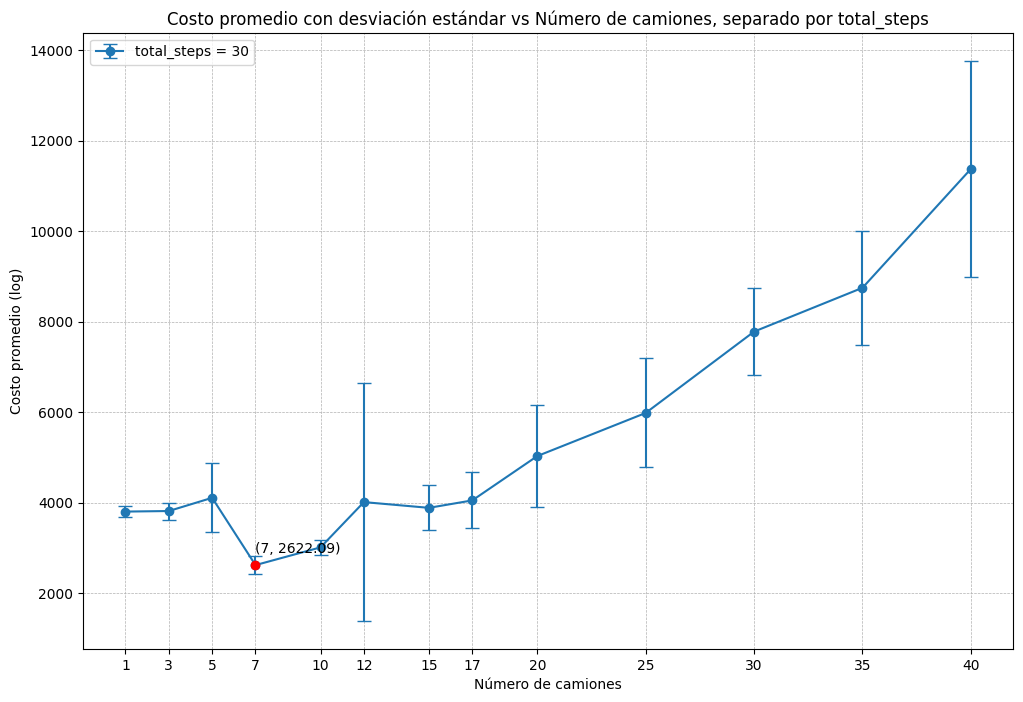

In [35]:
draw_graphs(df_estadisticas)

In [36]:
# import matplotlib.pyplot as plt

# # Extraer valores únicos de total_steps
# total_steps_values = df_estadisticas["total_steps"].unique()

# # Crear figura y ejes
# fig, axes = plt.subplots(nrows=len(total_steps_values), ncols=1, figsize=(10, 12), sharex=True)

# # Paleta de colores
# colors = plt.cm.viridis(np.linspace(0, 1, len(total_steps_values)))

# for ax, total_steps, color in zip(axes, total_steps_values, colors):
#     subset = df_estadisticas[df_estadisticas["total_steps"] == total_steps]

#     # Graficar línea con barra de error
#     ax.errorbar(subset["num_trucks"],
#                 subset["mean_cost"],
#                 yerr=subset["std_cost"],
#                 fmt='o-', capsize=5,
#                 color=color,
#                 label=f"total_steps = {total_steps}")

#     # Encontrar el mínimo de la curva
#     min_idx = subset["mean_cost"].idxmin()
#     min_x = subset.loc[min_idx, "num_trucks"]
#     min_y = subset.loc[min_idx, "mean_cost"]

#     # Marcar el mínimo con un punto y una etiqueta
#     ax.scatter(min_x, min_y, color='red', zorder=3, s=80, edgecolors='black', linewidth=1.2)
#     ax.text(min_x, min_y * 1.1, f"({min_x}, {min_y:.2f})", fontsize=10, verticalalignment="bottom", color='black')

#     # Aplicar escala logarítmica al eje Y
#     ax.set_title(f"Total Steps = {total_steps}", fontsize=12, fontweight='bold')
#     ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

# # Etiquetas generales
# plt.xlabel("Número de camiones", fontsize=12, fontweight='bold')
# fig.supylabel("Coste promedio", fontsize=12, fontweight='bold')
# fig.suptitle("Coste Promedio vs Número de Camiones y Número de Steps", fontsize=14, fontweight='bold')

# # Ajustar espaciado
# plt.xticks(df_estadisticas["num_trucks"].unique())
# plt.tight_layout(rect=[0, 0, 1, 0.96])

# # Mostrar gráfico
# plt.show()


In [37]:
import matplotlib.colors as mcolors

d = df_estadisticas['barrio_recogidas_avg'].loc[0]
# Crear el mapa centrado en Valencia
m = folium.Map(location=[39.4702, -0.3768], zoom_start=12, control_scale=True)

# Usar una escala de colores de rojo (bajo) a verde (alto)
colormap = mcolors.LinearSegmentedColormap.from_list("custom", ["green", "yellow", "red"])
norm = mcolors.Normalize(vmin=min(d.values()), vmax=max(d.values()))

for barrio in barrios_data:
    nombre = barrio['nombre']
    geo_shape = barrio.get('geo_shape', {})

    # Obtener coordenadas
    try:
        coords = geo_shape['geometry']['coordinates'][0]
    except (KeyError, IndexError, TypeError):
        continue

    coords_latlon = [(c[1], c[0]) for c in coords]

    # Asignar color según el valor del diccionario `d`
    valor = d.get(nombre, 0.0)  # Si no está en `d`, asumimos 0.0
    fill_color = mcolors.to_hex(colormap(norm(valor)))

    # Añadir polígono al mapa
    folium.Polygon(
        locations=coords_latlon,
        color="black",
        weight=1.5,
        fill=True,
        fill_color=fill_color,
        fill_opacity=0.6,
        popup=f"{nombre}: {valor:.2f}"
    ).add_to(m)

m

In [38]:
from itertools import combinations
from tqdm.notebook import tqdm

all_barrios_name = [b['nombre'] for b in barrios_data]
storage_combs = sorted([set(x) for x in combinations(all_barrios_name, 4)])

print(f'Total of: {len(storage_combs)} combinations...')

Total of: 2331890 combinations...


In [39]:
import numpy as np

mean_dist = np.mean(list(dist_matrix.values()))

storage_combs_filter = []
for comb in tqdm(storage_combs):
  aux = combinations(comb, 2)
  if not any([dist_matrix[(x, y)] < 2 * mean_dist for x, y in aux]):
    storage_combs_filter.append(comb)

  0%|          | 0/2331890 [00:00<?, ?it/s]

In [40]:
for comb in storage_combs_filter:
  for _ in range(10):
    simulator = Simulator(config=WasteCollectionConfig(num_trucks=5, 
                                                       total_steps=30, 
                                                       storage_barrios=comb,
                                                       data_dir='resultados_storages'),
                          scenario_cls=WasteCollectionScenario,
                          data_loader_cls=WasteCollectionDataLoader,
                          model_cls=WasteCollectionModel
                          )
    simulator.run()

Barrios almacenes seleccionados: {'RAFALELL-VISTABELLA', 'LA TORRE', 'MASSARROJOS', 'EL PALMAR'}
Camiones asignados a almacenes: ['EL PALMAR', 'LA TORRE', 'RAFALELL-VISTABELLA', 'LA TORRE', 'MASSARROJOS']

Datos de las rutas guardados en truck_routes_1.csv
Barrios almacenes seleccionados: {'RAFALELL-VISTABELLA', 'LA TORRE', 'MASSARROJOS', 'EL PALMAR'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'LA TORRE', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'EL PALMAR']

Datos de las rutas guardados en truck_routes_2.csv
Barrios almacenes seleccionados: {'RAFALELL-VISTABELLA', 'LA TORRE', 'MASSARROJOS', 'EL PALMAR'}
Camiones asignados a almacenes: ['EL PALMAR', 'RAFALELL-VISTABELLA', 'RAFALELL-VISTABELLA', 'LA TORRE', 'RAFALELL-VISTABELLA']

Datos de las rutas guardados en truck_routes_3.csv
Barrios almacenes seleccionados: {'RAFALELL-VISTABELLA', 'LA TORRE', 'MASSARROJOS', 'EL PALMAR'}
Camiones asignados a almacenes: ['RAFALELL-VISTABELLA', 'MASSARROJOS', 'RAFALELL-VISTABELLA', 'LA TORR

In [45]:
len(storage_combs_filter)

56

In [46]:
df_statistics = get_statistics(num_files_per_exp=10, 
                               num_trucks_list=[5], 
                               total_steps_list=[30],
                               storage_barrios=storage_combs_filter,
                               resultados_path='resultados_storages/')
df_statistics

,num_trucks,total_steps,storage_barrios,mean_cost,std_cost,barrio_recogidas_avg
0,5,30,"{RAFALELL-VISTABELLA, LA TORRE, MASSARROJOS, E...",6210.337203,157.997501,"{'RUSSAFA': 0.9296296296296297, 'LA TORRE': 4...."
1,5,30,"{RAFALELL-VISTABELLA, MASSARROJOS, PENYA-ROJA,...",5509.307044,135.660923,"{'RUSSAFA': 0.9296296296296297, 'RAFALELL-VIST..."
2,5,30,"{RAFALELL-VISTABELLA, MASSARROJOS, CAMI REAL, ...",5735.041597,146.255879,"{'RUSSAFA': 0.9259259259259258, 'RAFALELL-VIST..."
3,5,30,"{RAFALELL-VISTABELLA, LA FONTETA S.LLUIS, MASS...",5386.478329,82.301795,"{'RUSSAFA': 0.9333333333333333, 'RAFALELL-VIST..."
4,5,30,"{RAFALELL-VISTABELLA, LA PUNTA, MASSARROJOS, E...",6295.281419,110.799206,"{'RUSSAFA': 0.9333333333333333, 'LA PUNTA': 4...."
5,5,30,"{NATZARET, RAFALELL-VISTABELLA, BENIMAMET, EL ...",6416.511902,167.459629,"{'RUSSAFA': 0.9259259259259258, 'NATZARET': 3...."
6,5,30,"{RAFALELL-VISTABELLA, EL GRAU, BENIMAMET, EL P...",6965.677545,156.952602,"{'RUSSAFA': 0.9259259259259258, 'RAFALELL-VIST..."
7,5,30,"{RAFALELL-VISTABELLA, CAMI FONDO, MASSARROJOS,...",5373.673622,118.358189,"{'RUSSAFA': 0.9333333333333333, 'CAMI FONDO': ..."
8,5,30,"{RAFALELL-VISTABELLA, MASSARROJOS, MALILLA, EL...",5160.215201,178.118135,"{'RUSSAFA': 0.9333333333333333, 'MALILLA': 4.3..."
9,5,30,"{RAFALELL-VISTABELLA, MASSARROJOS, SANT MARCEL...",5424.332827,146.345754,"{'RUSSAFA': 0.9296296296296297, 'SANT MARCEL.L..."


In [42]:
import pandas as pd
import folium
import json
import ast  # For converting route string to Python list
import random  # For generating random colors


def draw_routes(route_path):
    # 1. Read the CSV file with routes
    routes = pd.read_csv(route_path)
    # This CSV should have columns like: step, truck_id, route, cost_incurred

    # 2. Load neighborhood coordinates from JSON
    with open("barris-barrios.json", "r", encoding="utf-8") as f:
        barrios_data = json.load(f)

    # Create a dictionary with {neighborhood_name: (lat, lon)}
    barrio_coords = {}
    for b in barrios_data:
        name = b["nombre"]
        lat = b["geo_point_2d"]["lat"]
        lon = b["geo_point_2d"]["lon"]
        barrio_coords[name] = (lat, lon)

    # 3. Assign a unique color to each truck_id
    # Generate a color palette or assign predefined colors
    # Here, we'll assign random colors to each truck
    unique_trucks = routes['truck_id'].unique()
    truck_colors = {}
    random.seed(42)  # For reproducibility
    for truck in unique_trucks:
        # Generate a random color in HEX format
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        truck_colors[truck] = color

    # 4. Create a Folium map centered in Valencia (adjust as needed)
    valencia_center = [39.4699, -0.3763]  # Adjust to your desired location
    m = folium.Map(location=valencia_center, zoom_start=12)

    # 5. Organize routes by step
    steps = routes['step'].unique()
    steps = sorted(steps)  # Optional: sort the steps

    # Create a dictionary to hold FeatureGroups for each step
    step_layers = {}
    for step in steps:
        # Create a FeatureGroup for each step
        fg = folium.FeatureGroup(name=f"Step {step}")
        step_layers[step] = fg
        m.add_child(fg)

    # 6. Iterate through the DataFrame and add routes to corresponding step layers
    for idx, row in routes.iterrows():
        step = row["step"]
        truck_id = row["truck_id"]
        cost = row["cost_incurred"]

        # The 'route' column is typically a string like "['Barrio1','Barrio2','Barrio3']".
        # Use ast.literal_eval to convert it to a Python list.
        route_str = row["route"]
        try:
            route_list = ast.literal_eval(route_str)
        except:
            route_list = []

        # Convert each neighborhood name to (lat, lon)
        points = []
        for barrio_name in route_list:
            if barrio_name in barrio_coords:
                points.append(barrio_coords[barrio_name])

        # Draw the route with PolyLine if there is more than one point
        if len(points) > 1:
            folium.PolyLine(
                locations=points,
                color=truck_colors.get(truck_id, "blue"),  # Use the truck's color
                weight=3,
                tooltip=f"Truck {truck_id}, Step {step}, Cost={cost:.2f}"
            ).add_to(step_layers[step])

            # Marker for start
            folium.Marker(
                location=points[0],
                popup=f"Start (Truck {truck_id}, Step {step})",
                icon=folium.Icon(color='green')
            ).add_to(step_layers[step])

            # Marker for end
            folium.Marker(
                location=points[-1],
                popup=f"End (Truck {truck_id}, Step {step})",
                icon=folium.Icon(color='red')
            ).add_to(step_layers[step])

        # If the route has a single point, draw a unique marker
        elif len(points) == 1:
            folium.Marker(
                location=points[0],
                popup=f"Single Point Route - Truck {truck_id}, Step {step}",
                icon=folium.Icon(color=truck_colors.get(truck_id, "blue"))
            ).add_to(step_layers[step])

    # 7. Add a layer control to the map to toggle steps
    folium.LayerControl(collapsed=False).add_to(m)

    # 8. (Optional) Add a legend for truck colors
    # Create a HTML string for the legend
    legend_html = '''
        <div style="position: fixed;
        bottom: 50px; left: 50px; width: 150px; height: auto;
        border:2px solid grey; z-index:9999; font-size:14px;
        background-color:white;
        padding: 10px;
        ">
        <b>Truck Colors</b><br>
    '''
    for truck, color in truck_colors.items():
        legend_html += f'&nbsp;<i style="background:{color};width:10px;height:10px;display:inline-block;"></i>&nbsp;Truck {truck}<br>'
    legend_html += '</div>'

    m.get_root().html.add_child(folium.Element(legend_html))

    # 9. Add neighborhood markers
    for barrio in barrios_data:
        nombre = barrio['nombre']
        geo_shape = barrio.get('geo_shape', {})

        # Localizamos las coordenadas:
        try:
            coords = geo_shape['geometry']['coordinates'][0]
        except (KeyError, IndexError, TypeError):
            print(f"No se pudieron leer las coordenadas del polígono para {nombre}")
            continue

        coords_latlon = [(c[1], c[0]) for c in coords]

        # Añadimos el polígono al mapa
        folium.Polygon(
            locations=coords_latlon,
            color="black",        # Borde
            weight=0.5,           # Grosor del borde
            fill=True,
            fill_color="#FFFF00",  # Color de relleno, amarillo
            fill_opacity=0.01,
            popup=nombre
        ).add_to(m)

        # Agregar un marcador al centro de cada barrio
        if nombre in barrio_coords:
            lat, lon = barrio_coords[nombre]
            folium.Marker(
                location=[lat, lon],
                popup=f"Barrio: {nombre}",
                icon=folium.Icon(color="blue", icon="info-sign")
            ).add_to(m)

    # 10. Display the map
    m